In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import sys
sys.path.insert(0, "../input/weightedboxesfusion")
from ensemble_boxes import *
import glob

In [3]:
!cp -r ../input/yolov5tta/yolov5tta/* .
!cp -r ../input/yolov5git/yolov5/utils/* ./utils/


In [4]:
!cp ../input/yolo5tta4/yolo.py ./models/

In [5]:
import argparse

from utils.datasets import *
from utils.utils import *


def detect(save_img=False):
    weights, imgsz = opt.weights,opt.img_size
    source = '../input/global-wheat-detection/test/'
    
    # Initialize
    device = torch_utils.select_device(opt.device)
    half = False
    # Load model

    model = torch.load(weights, map_location=device)['model'].to(device).float().eval()

    dataset = LoadImages(source, img_size=1024)

    t0 = time.time()
    img = torch.zeros((1, 3, imgsz, imgsz), device=device)  # init img
    all_path=[]
    all_bboxex =[]
    all_score =[]
    for path, img, im0s, vid_cap in dataset:
        print(im0s.shape)
        img = torch.from_numpy(img).to(device)
        img = img.half() if half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)

        # Inference
        t1 = torch_utils.time_synchronized()
        bboxes_2 = []
        score_2 = []
        if True:
            pred = model(img, augment=opt.augment)[0]
            pred = non_max_suppression(pred, 0.4, opt.iou_thres,fast=True, classes=None, agnostic=False)
            t2 = torch_utils.time_synchronized()

            bboxes = []
            score = []
            # Process detections
            for i, det in enumerate(pred):  # detections per image
                p, s, im0 = path, '', im0s
                gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  #  normalization gain whwh
                if det is not None and len(det):
                    det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()
                    for c in det[:, -1].unique():
                        n = (det[:, -1] == c).sum()  # detections per class

                    for *xyxy, conf, cls in det:
                        if True:  # Write to file
                            xywh = torch.tensor(xyxy).view(-1).numpy()  # normalized xywh
#                             xywh[2] = xywh[2]-xywh[0]
#                             xywh[3] = xywh[3]-xywh[1]
                            bboxes.append(xywh)
                            score.append(conf)
            bboxes_2.append(bboxes)
            score_2.append(score)
        all_path.append(path)
        all_score.append(score_2)
        all_bboxex.append(bboxes_2)
    return all_path,all_score,all_bboxex


if __name__ == '__main__':
    class opt:
        weights = "../input/yolov5pth/best_yolov5x_fold1.pt"
        img_size = 1024
        conf_thres = 0.1
        iou_thres = 0.94
        augment = True
        device = '0'
        classes=None
        agnostic_nms = True
        
    opt.img_size = check_img_size(opt.img_size)
    print(opt)

    with torch.no_grad():
        res = detect()

<class '__main__.opt'>
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)



/opt/conda/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'models.yolo.Model' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'models.common.Conv' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = Tr

image 1/10 ../input/global-wheat-detection/test/2fd875eaa.jpg: (1024, 1024, 3)
image 2/10 ../input/global-wheat-detection/test/348a992bb.jpg: (1024, 1024, 3)
image 3/10 ../input/global-wheat-detection/test/51b3e36ab.jpg: (1024, 1024, 3)
image 4/10 ../input/global-wheat-detection/test/51f1be19e.jpg: (1024, 1024, 3)
image 5/10 ../input/global-wheat-detection/test/53f253011.jpg: (1024, 1024, 3)
image 6/10 ../input/global-wheat-detection/test/796707dd7.jpg: (1024, 1024, 3)
image 7/10 ../input/global-wheat-detection/test/aac893a91.jpg: (1024, 1024, 3)
image 8/10 ../input/global-wheat-detection/test/cb8d261a3.jpg: (1024, 1024, 3)
image 9/10 ../input/global-wheat-detection/test/cc3532ff6.jpg: (1024, 1024, 3)
image 10/10 ../input/global-wheat-detection/test/f5a1f0358.jpg: (1024, 1024, 3)


In [6]:
def run_wbf(boxes,scores, image_size=1024, iou_thr=0.4, skip_box_thr=0.34, weights=None):
#     boxes =boxes/(image_size-1)
    labels0 = [np.ones(len(scores[idx])) for idx in range(len(scores))]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels0, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
#     boxes = boxes*(image_size-1)
#     boxes = boxes
    return boxes, scores, labels

In [7]:
all_path,all_score,all_bboxex = res

In [8]:
results =[]
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))
    return " ".join(pred_strings)
for row in range(len(all_path)):
    image_id = all_path[row].split("/")[-1].split(".")[0]
    boxes = all_bboxex[row]
    scores = all_score[row]
    boxes, scores, labels = run_wbf(boxes,scores)
    boxes = (boxes*1024/1024).astype(np.int32).clip(min=0, max=1023)
    boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
    boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
    result = {'image_id': image_id,'PredictionString': format_prediction_string(boxes, scores)}
    results.append(result)
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])

In [9]:
!rm -rf ./*

In [10]:
test_df.to_csv('submission.csv', index=False)
test_df.head()

,image_id,PredictionString
0,2fd875eaa,0.7426 464 352 126 96 0.7361 105 584 141 84 0....
1,348a992bb,0.8082 730 224 146 89 0.7501 138 40 120 88 0.7...
2,51b3e36ab,0.7407 503 361 309 125 0.6969 336 462 81 150 0...
3,51f1be19e,0.5844 843 273 125 196 0.5839 502 467 195 106 ...
4,53f253011,0.7735 466 466 148 197 0.7288 622 102 117 140 ...


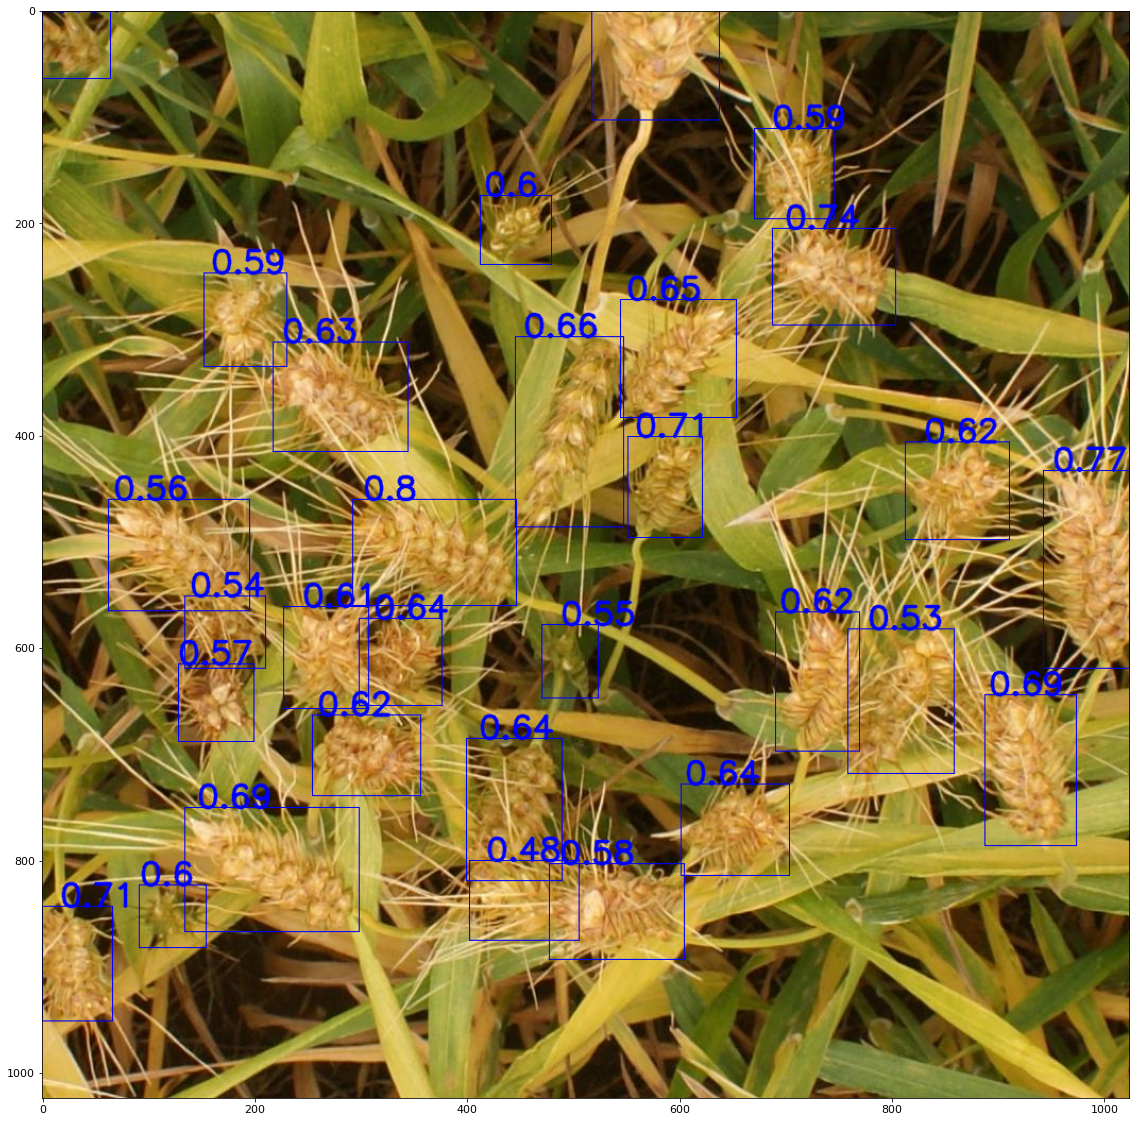

In [11]:
size = 300
idx =-1
font = cv2.FONT_HERSHEY_SIMPLEX 
image = image = cv2.imread(all_path[idx], cv2.IMREAD_COLOR)
# fontScale 
fontScale = 1
# boxes = all_bboxex[idx]
# scores = all_score[idx]
# Blue color in BGR 
color = (255, 0, 0) 

# Line thickness of 2 px 
thickness = 2
for b,s in zip(boxes,scores):
    image = cv2.rectangle(image, (b[0],b[1]), (b[0]+b[2],b[1]+b[3]), (255,0,0), 1) 
    image = cv2.putText(image, '{:.2}'.format(s), (b[0]+np.random.randint(20),b[1]), font,  
                   fontScale, color, thickness, cv2.LINE_AA)
plt.figure(figsize=[20,20])
plt.imshow(image[:,:,::-1])
plt.show()